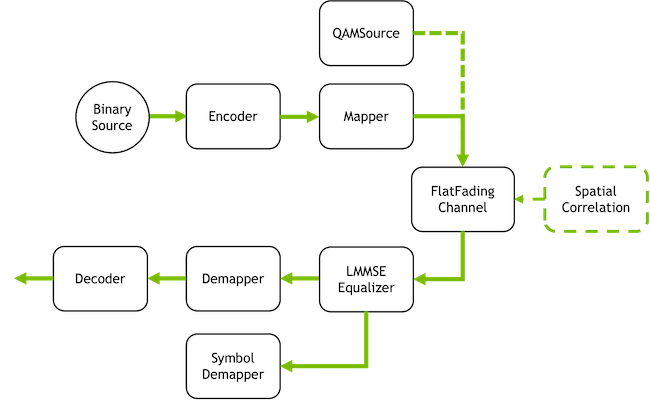

# 1 Uncoded MIMO System with ZF,LMMSE Equalizers

Number of GPUs available : 0
x =
 tf.Tensor(
[[ 0.9486833+0.9486833j -0.3162278+0.9486833j -0.3162278+0.9486833j
   0.9486833-0.9486833j]
 [ 0.3162278-0.3162278j -0.3162278-0.9486833j  0.3162278+0.3162278j
   0.3162278+0.3162278j]
 [ 0.9486833+0.9486833j  0.9486833-0.3162278j -0.3162278+0.9486833j
  -0.3162278-0.3162278j]
 ...
 [ 0.3162278-0.9486833j -0.3162278+0.3162278j -0.9486833-0.3162278j
  -0.3162278+0.3162278j]
 [ 0.9486833-0.3162278j  0.3162278-0.9486833j  0.3162278-0.3162278j
   0.3162278+0.9486833j]
 [-0.9486833-0.3162278j  0.9486833+0.3162278j  0.3162278+0.9486833j
   0.3162278-0.3162278j]], shape=(1024, 4), dtype=complex64)
x.shape =
 (1024, 4)
h.shape =
 (1024, 16, 4)
y.shape =
 (1024, 16)


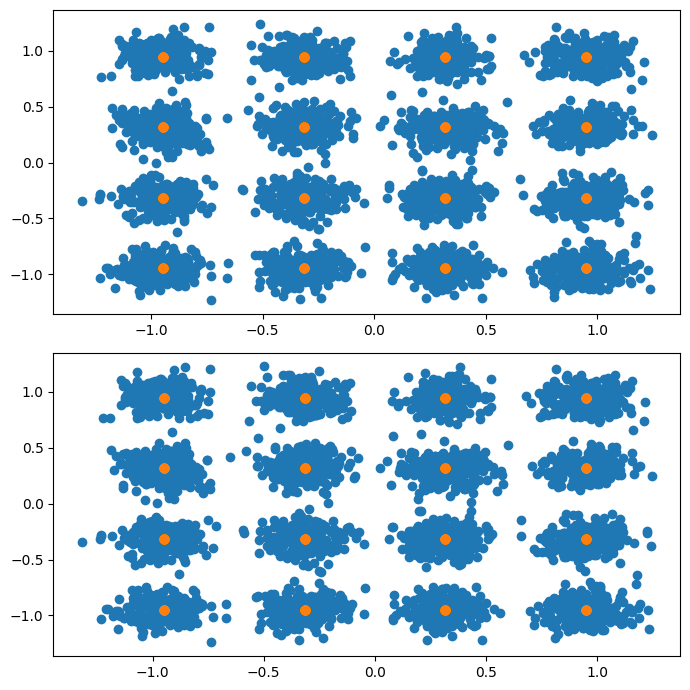

In [3]:
# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

# Simple Uncoded Transmission
NUM_TX_ANT = 4 # Number of Transmitter Antennas
NUM_RX_ANT = 16 # Number of Receiver Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallel in 3 batches
qam_source = QAMSource(NUM_BITS_PER_SYMBOL)
x = qam_source([BATCH_SIZE, NUM_TX_ANT])
print('x =\n',x)
print('x.shape =\n',x.shape)

# Create `FlatFadingChannel` to simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)
no = 0.2 # Noise Variance of the Transmission Channel

# y and h are the Channel Output and Channel Realizations, respectively.
y, h = channel([x, no]) # x = qam_source([batch_size, num_tx_ant]), no = 0.2
print('h.shape =\n',h.shape)
print('y.shape =\n',y.shape)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)

# plt.axes().set_aspect(1.0)
# plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf));
# plt.scatter(np.real(x), np.imag(x));

plt.figure(figsize=(7,7))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.subplot(2,1,1)
plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf));
plt.scatter(np.real(x), np.imag(x));
plt.subplot(2,1,2)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse));
plt.scatter(np.real(x), np.imag(x));
# plt.subplot(3,1,3)
# plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
plt.tight_layout()



# 2 Uncoded MIMO SER under Flat Fading Channel

## 2.1 Without Spatial Correlation

Number of GPUs available : 0
b shape = (32, 4, 512)
x shape = (32, 4, 128)


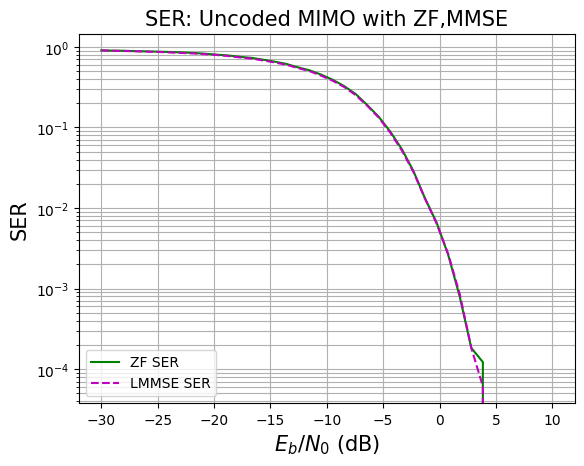

In [18]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)



for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,40):

    snrs += [EBN0_DB]

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    # print('no =',no)

    x_ind = symbol_demapper([x, no])
    # print('x_ind.shape =',x_ind.shape)
    # print('x_ind =',x_ind)

    # y and h are the Channel Output and Channel Realizations, respectively.
    y, h = flatfading_channel([x_reshape, no])
    # print('h.shape =\n',h.shape)
    # print('y.shape =\n',y.shape)

    s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

    x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    x_hat_zf = tf.reshape(x_hat_zf, shape)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    no_eff_zf = tf.reshape(no_eff_zf, shape)
    no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)

    # llr_zf = demapper([x_hat_zf, no_eff_zf])
    # b_hat_zf = decoder(llr_zf)

    x_ind_hat_zf = symbol_demapper([x_hat_zf, no])
    # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
    # print('x_ind_hat_zf =',x_ind_hat_zf)
    x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no])
    # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

    ser_zf = compute_ser(x_ind, x_ind_hat_zf)
    ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
    sers_zf += [ser_zf]
    sers_lmmse += [ser_lmmse]

# print(snrs)
# print(sers_zf)
# print(sers_lmmse)
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
# plt.semilogy(snrs, bers, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers_zf, 'g', label='ZF SER')
# plt.semilogy(snrs, bers_LDPC, 'r--', label='LDPC BER')
plt.semilogy(snrs, sers_lmmse, 'm--', label='LMMSE SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

# plt.figure(figsize=(7,7))
# plt.axes().set_aspect(1)
# plt.grid(True)
# plt.title('Channel output')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.subplot(2,1,1)
# plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf))
# plt.scatter(np.real(x), np.imag(x))
# plt.subplot(2,1,2)
# plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
# plt.scatter(np.real(x), np.imag(x))
# # plt.subplot(3,1,3)
# # plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
# plt.tight_layout()



## ZF, LMMSE, DIP

2023-05-12 18:12:53.821157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of GPUs available : 0
b shape = (1, 4, 8)
x shape = (1, 4, 2)


/Users/im/Documents/GitHub/sionna/Jupyter Notebooks/xyDIP.py:103: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/Copy.cpp:276.)
  y_torch = torch.from_numpy((Y[bs]).numpy()).reshape(1, 1, self.user_num, 1).type(dtype)


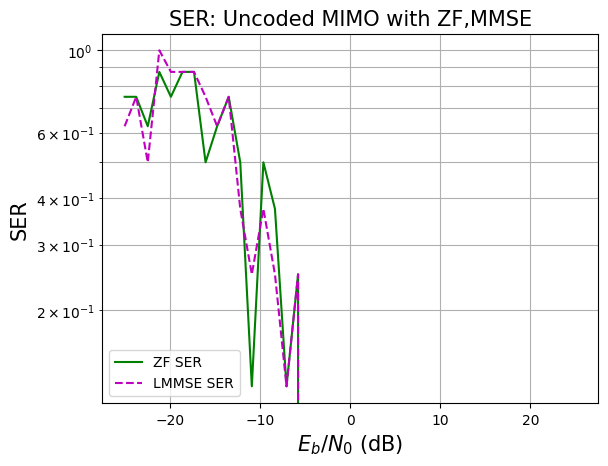

In [1]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from xyDIP import DeepImagePrior

k = 8 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# Deep Image Prior
dip = DeepImagePrior(user_num=NUM_RX_ANT,      # Number of transmitted symbol in real domain
                    M=16,              # Modulation order, 4 for 4QAM, 16 for 16QAM; 16QAM: 4 bits per symbol
                    iteration=100,    # Number of max iterations used for DIP: 100
                    LR=0.01,          # Learning rate,  typically set to 0.01
                    buffer_size=30,   # Iterations stored,  typically set to 30
                    threshold=0.001,  # Threshold of DIP stop,, typically set to 0.001
                    stop=True)        # True

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)



for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,40):

    snrs += [EBN0_DB]

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    # print('no =',no)

    x_ind = symbol_demapper([x, no])
    # print('x_ind.shape =',x_ind.shape)
    # print('x_ind =',x_ind)

    # y and h are the Channel Output and Channel Realizations, respectively.
    y, h = flatfading_channel([x_reshape, no])
    # print('h.shape =\n',h.shape)
    # print('y.shape =\n',y.shape)

    s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

    x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    x_dip_ay,num_stop_point = dip.DIP(y,h)
    # print('x_dip_ay.shape =',x_dip_ay.shape)
    # print('x_dip_ay =',x_dip_ay)
    # print('num_stop_point =',num_stop_point)

    x_hat_zf = tf.reshape(x_hat_zf, shape)
    # print('x_hat_zf.shape =',x_hat_zf.shape)
    x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
    # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

    no_eff_zf = tf.reshape(no_eff_zf, shape)
    no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)

    # llr_zf = demapper([x_hat_zf, no_eff_zf])
    # b_hat_zf = decoder(llr_zf)

    x_ind_hat_zf = symbol_demapper([x_hat_zf, no])
    # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
    # print('x_ind_hat_zf =',x_ind_hat_zf)
    x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no])
    # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

    ser_zf = compute_ser(x_ind, x_ind_hat_zf)
    ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
    sers_zf += [ser_zf]
    sers_lmmse += [ser_lmmse]

# print(snrs)
# print(sers_zf)
# print(sers_lmmse)
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
# plt.semilogy(snrs, bers, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers_zf, 'g', label='ZF SER')
# plt.semilogy(snrs, bers_LDPC, 'r--', label='LDPC BER')
plt.semilogy(snrs, sers_lmmse, 'm--', label='LMMSE SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

# plt.figure(figsize=(7,7))
# plt.axes().set_aspect(1)
# plt.grid(True)
# plt.title('Channel output')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.subplot(2,1,1)
# plt.scatter(np.real(x_hat_zf), np.imag(x_hat_zf))
# plt.scatter(np.real(x), np.imag(x))
# plt.subplot(2,1,2)
# plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
# plt.scatter(np.real(x), np.imag(x))
# # plt.subplot(3,1,3)
# # plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
# plt.tight_layout()



## 2.2 With Spatial Correlation

TX_ANT_CORRELATION_INDEX = 0.1~0.5~0.9

RX_ANT_CORRELATION_INDEX = 0.1~0.5~0.9

### 未标记

Number of GPUs available : 0
b shape = (32, 4, 512)
x shape = (32, 4, 128)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.9


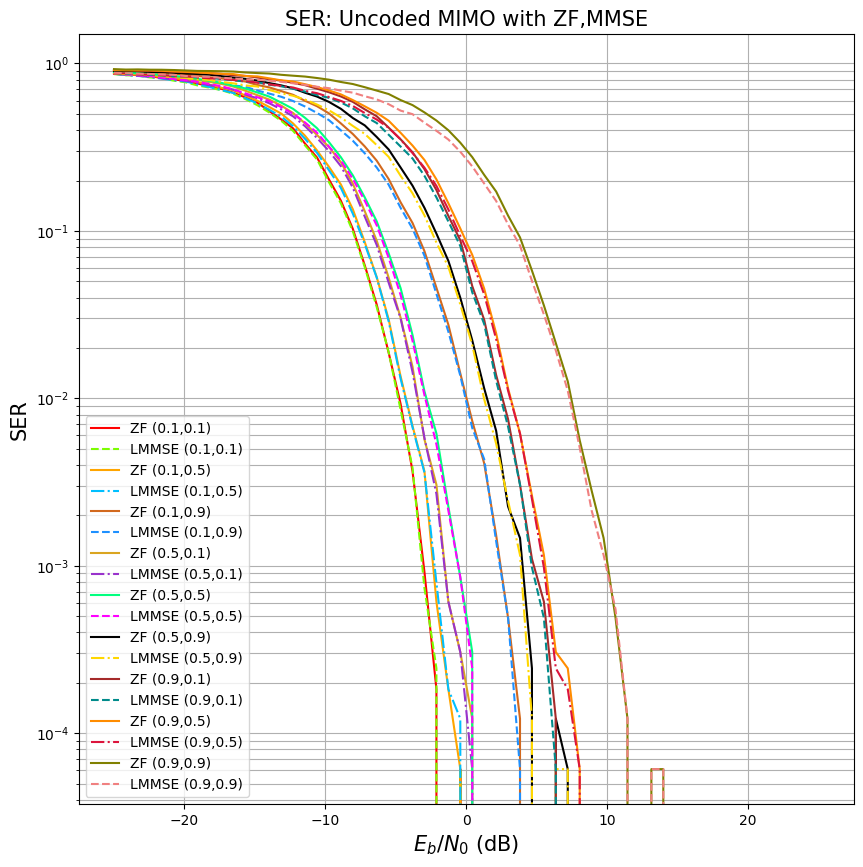

In [63]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
# TX_ANT_CORRELATION_INDEX = 0.9 # 0.4
# RX_ANT_CORRELATION_INDEX = 0.1 # 0.9
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,60)
bers = []
sers_zf = np.zeros((9, 60))
sers_lmmse = np.zeros((9, 60))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# # Adding Spatial Correlation
# # Create transmit and receive correlation matrices
# r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
# r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
# # print('r_tx =',r_tx)
# # print('r_rx =',r_rx)

# # Add the spatial correlation model to the channel
# flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,50):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            no_eff_zf = tf.reshape(no_eff_zf, shape)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.legend(loc='lower left', fontsize=10)
        i = i + 1
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()


### 标记 SNR=0dB SER值 

Number of GPUs available : 0
b shape = (1024, 4, 512)
x shape = (1024, 4, 128)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.9


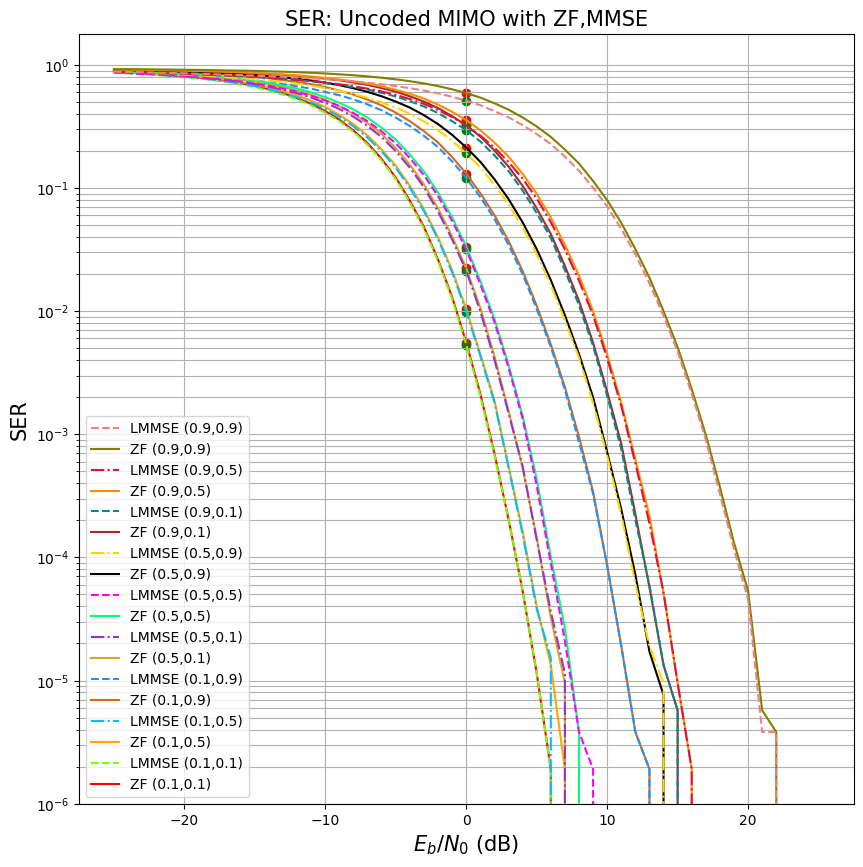

In [112]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
# print('snrs[25] =',snrs[25])
bers = []
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# # Adding Spatial Correlation
# # Create transmit and receive correlation matrices
# r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
# r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
# # print('r_tx =',r_tx)
# # print('r_rx =',r_rx)

# # Add the spatial correlation model to the channel
# flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            no_eff_zf = tf.reshape(no_eff_zf, shape)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        # plt.text(snrs[25], sers_zf[i][25], '({},{}).format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX)', \
        #          fontsize=8, color = "r", style = "italic", weight = "light", verticalalignment='center', \
        #          horizontalalignment='right', rotation=90)
        plt.scatter(snrs[25], sers_zf[i][25], marker='o', color='red')
        plt.scatter(snrs[25], sers_lmmse[i][25], marker='o', color='green')
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=10)
        i = i + 1
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()


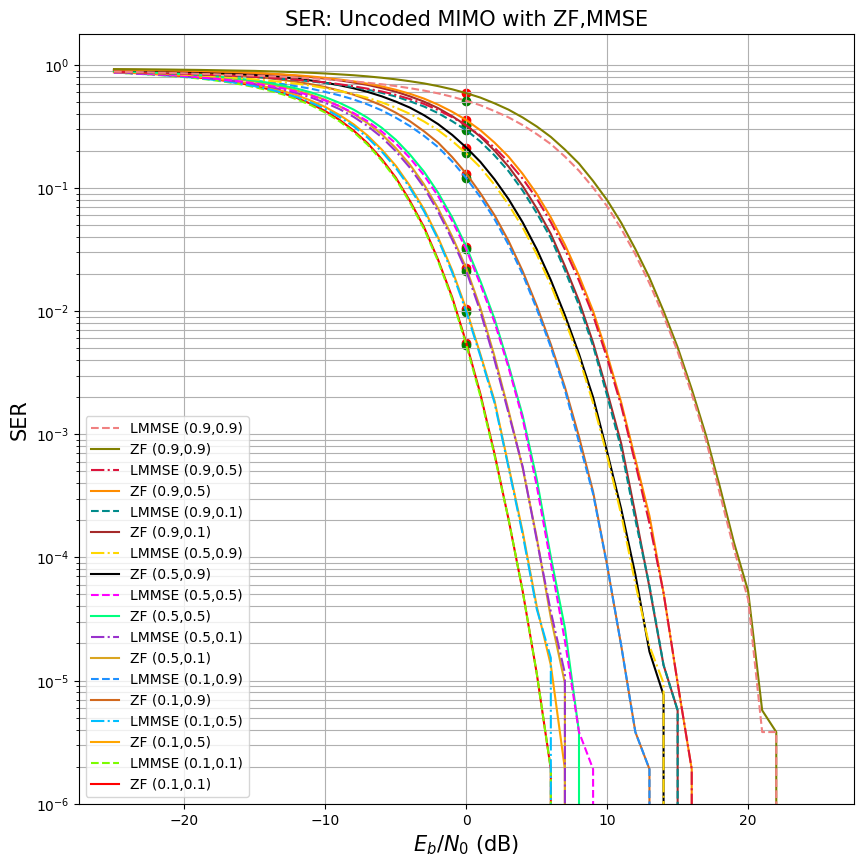

### 标记 SER=10^-2dB SNR值 

Number of GPUs available : 0
b shape = (32, 4, 512)
x shape = (32, 4, 128)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.9


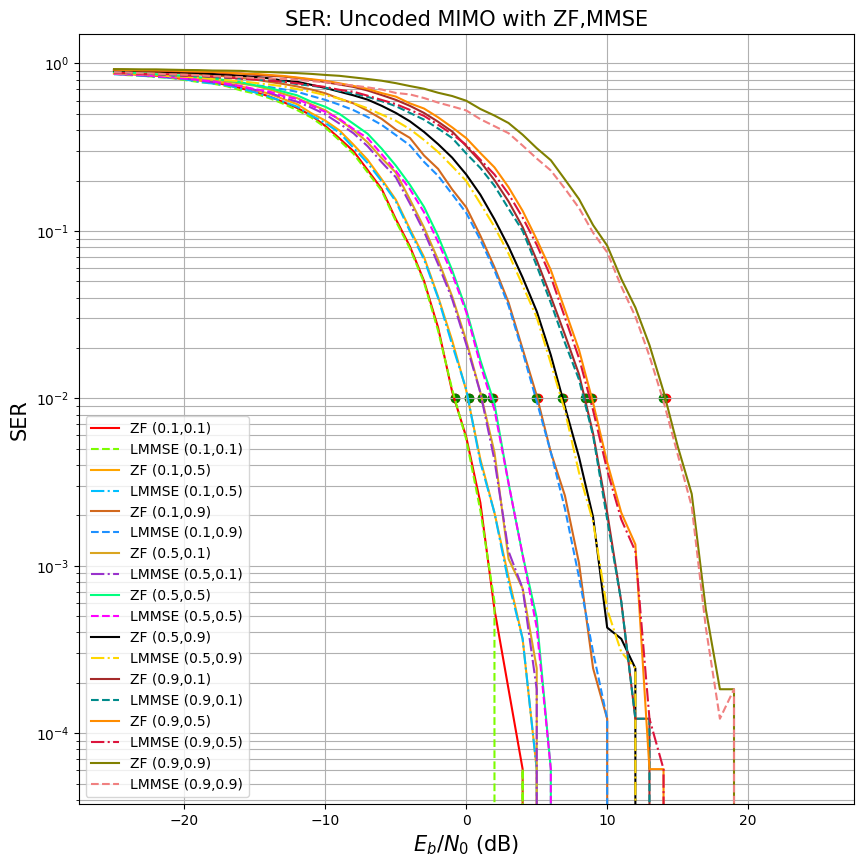

In [106]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

from scipy.interpolate import interp1d

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
# print('snrs[25] =',snrs[25])
bers = []
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# # Adding Spatial Correlation
# # Create transmit and receive correlation matrices
# r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
# r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
# # print('r_tx =',r_tx)
# # print('r_rx =',r_rx)

# # Add the spatial correlation model to the channel
# flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            no_eff_zf = tf.reshape(no_eff_zf, shape)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        sers_zf_inv = sers_zf[i][::-1]
        sers_lmmse_inv = sers_lmmse[i][::-1]
        snr_interp_zf = np.interp(0.01,sers_zf_inv,snrs)
        snr_interp_lmmse = np.interp(0.01,sers_lmmse_inv,snrs)
        plt.scatter(-snr_interp_zf, 0.01, marker='o', color='red')
        plt.scatter(-snr_interp_lmmse, 0.01, marker='o', color='green')
        plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.legend(loc='lower left', fontsize=10)
        i = i + 1
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()


# 3 Coded (LDPC) MIMO BER under Flat Fading Channel

## 3.1 BER Without LDPC

Number of GPUs available : 0
b shape = (32, 4, 512)
x shape = (32, 4, 128)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.9


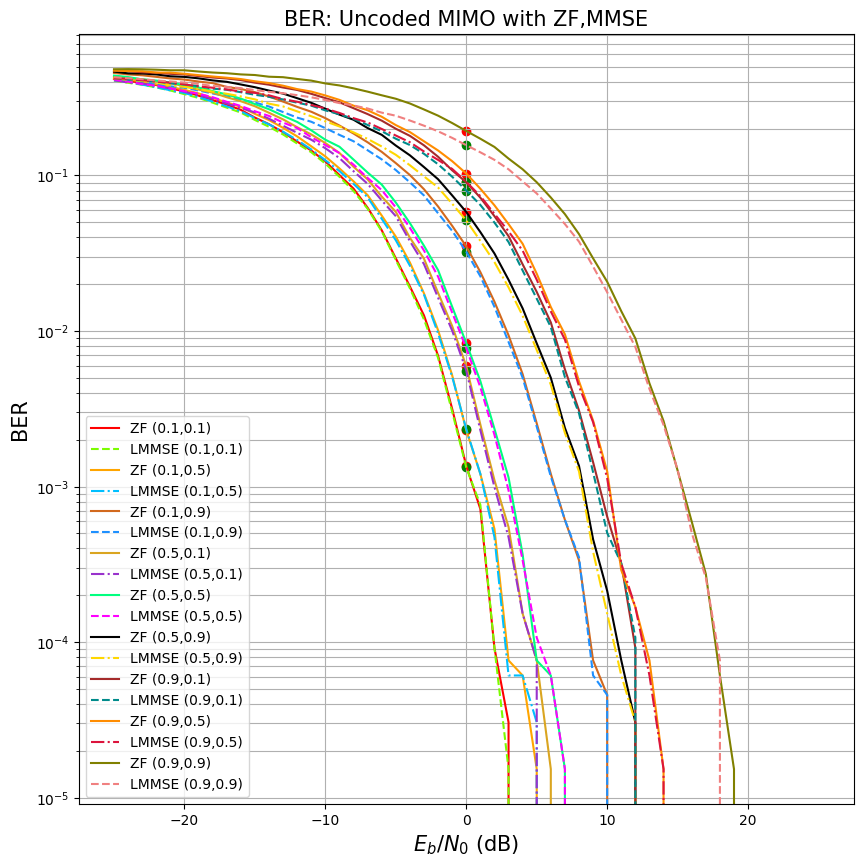

In [57]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
# print('snrs[25] =',snrs[25])
bers_zf = np.zeros((9, 51))
bers_lmmse = np.zeros((9, 51))
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

shape_b = tf.shape(b)

x = mapper(b)
print('x shape =',x.shape)

shape_x = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# # Adding Spatial Correlation
# # Create transmit and receive correlation matrices
# r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
# r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
# # print('r_tx =',r_tx)
# # print('r_rx =',r_rx)

# # Add the spatial correlation model to the channel
# flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape_x)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape_x)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
            no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            llr_zf = demapper([x_hat_zf, no_eff_zf])
            llr_lmmse = demapper([x_hat_lmmse, no_eff_lmmse])
            
            b_hat_zf = hard_decisions(llr_zf)
            b_hat_lmmse = hard_decisions(llr_lmmse)

            ber_zf = compute_ber(b, b_hat_zf)
            ber_lmmse = compute_ber(b, b_hat_lmmse)

            bers_zf[i][j] = ber_zf
            bers_lmmse[i][j] = ber_lmmse

            # no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        plt.semilogy(snrs, bers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, bers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        # plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
        #              label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        # plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
        #              label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.scatter(snrs[25], bers_zf[i][25], marker='o', color='red')
        plt.scatter(snrs[25], bers_lmmse[i][25], marker='o', color='green')
        plt.legend(loc='lower left', fontsize=10)
        i = i + 1
title = "BER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "BER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()

## 3.2 BER With LDPC

### Batch Size: 32

Number of GPUs available : 0
b shape = (32, 4, 512)
x shape = (32, 4, 256)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.5
RX_ANT_CORRELATION_INDEX = 0.9
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.1
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.5
TX_ANT_CORRELATION_INDEX = 0.9
RX_ANT_CORRELATION_INDEX = 0.9


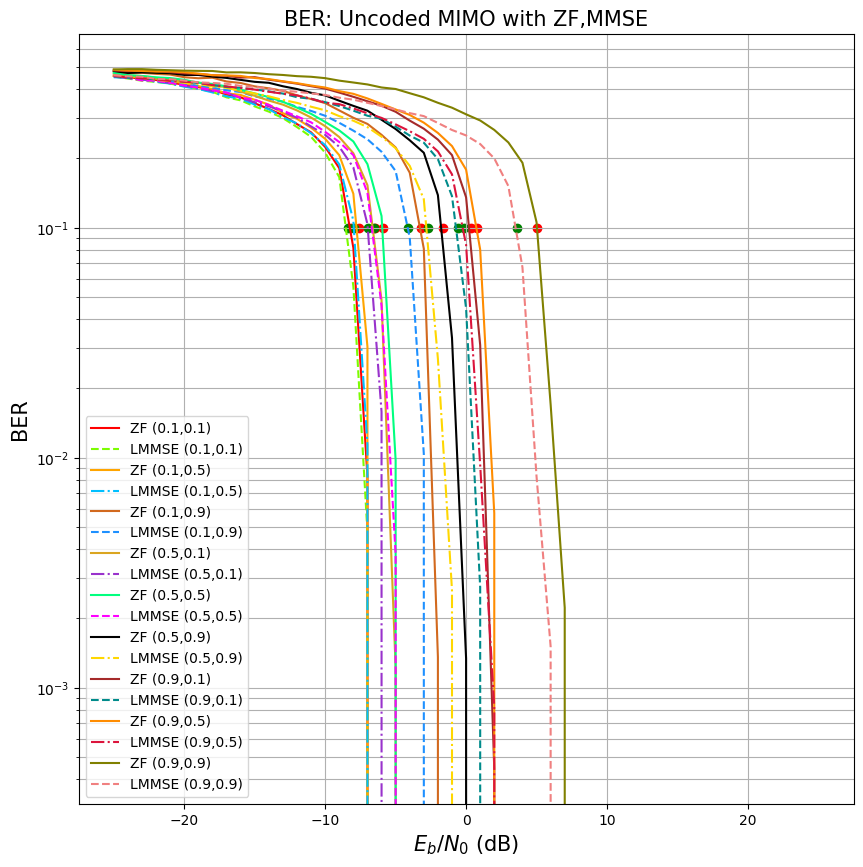

In [114]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

CODERATE = 0.5
n = 1024
k = int(n*CODERATE) # Block Length: 512
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
bers_zf = np.zeros((9, 51))
bers_lmmse = np.zeros((9, 51))
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

shape_b = tf.shape(b)

codewords = LDPC_encoder(b)

x = mapper(codewords)
print('x shape =',x.shape)

shape_x = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    # Create transmit correlation matrices
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    # print('r_tx =',r_tx)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        
        # Create receive correlation matrices
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        # print('r_rx =',r_rx)
        
        # Add Spatial Correlation to the channel
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        
        # Configure BER/SER Curves for Different Appearance
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape_x)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape_x)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
            no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            llr_zf = demapper([x_hat_zf, no_eff_zf])
            llr_lmmse = demapper([x_hat_lmmse, no_eff_lmmse])
            
            # b_hat_zf = hard_decisions(llr_zf)
            # b_hat_lmmse = hard_decisions(llr_lmmse)

            b_hat_zf = LDPC_decoder(llr_zf)
            b_hat_lmmse = LDPC_decoder(llr_lmmse)

            ber_zf = compute_ber(b, b_hat_zf)
            ber_lmmse = compute_ber(b, b_hat_lmmse)

            bers_zf[i][j] = ber_zf
            bers_lmmse[i][j] = ber_lmmse

            # no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        bers_zf_inv = bers_zf[i][::-1]
        bers_lmmse_inv = bers_lmmse[i][::-1]
        snr_interp_zf = np.interp(0.1,bers_zf_inv,snrs)
        snr_interp_lmmse = np.interp(0.1,bers_lmmse_inv,snrs)
        plt.scatter(-snr_interp_zf, 0.1, marker='o', color='red')
        plt.scatter(-snr_interp_lmmse, 0.1, marker='o', color='green')
        plt.semilogy(snrs, bers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, bers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.legend(loc='lower left', fontsize=10)
        i = i + 1
title = "BER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "BER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()

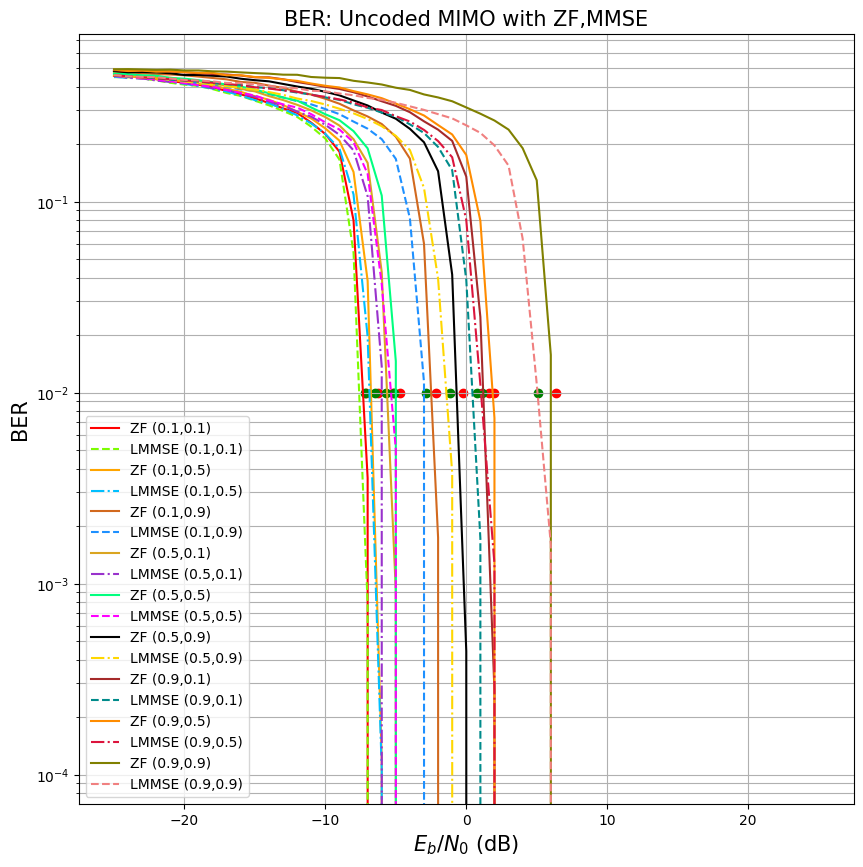

### Batch Size: 1024

In [ ]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

CODERATE = 0.5
n = 1024
k = int(n*CODERATE) # Block Length: 512
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
bers_zf = np.zeros((9, 51))
bers_lmmse = np.zeros((9, 51))
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

shape_b = tf.shape(b)

codewords = LDPC_encoder(b)

x = mapper(codewords)
print('x shape =',x.shape)

shape_x = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    # Create transmit correlation matrices
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    # print('r_tx =',r_tx)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        
        # Create receive correlation matrices
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        # print('r_rx =',r_rx)
        
        # Add Spatial Correlation to the channel
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        
        # Configure BER/SER Curves for Different Appearance
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape_x)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape_x)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
            no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            llr_zf = demapper([x_hat_zf, no_eff_zf])
            llr_lmmse = demapper([x_hat_lmmse, no_eff_lmmse])
            
            # b_hat_zf = hard_decisions(llr_zf)
            # b_hat_lmmse = hard_decisions(llr_lmmse)

            b_hat_zf = LDPC_decoder(llr_zf)
            b_hat_lmmse = LDPC_decoder(llr_lmmse)

            ber_zf = compute_ber(b, b_hat_zf)
            ber_lmmse = compute_ber(b, b_hat_lmmse)

            bers_zf[i][j] = ber_zf
            bers_lmmse[i][j] = ber_lmmse

            # no_eff_zf = tf.reshape(no_eff_zf, shape_x)
            # no_eff_lmmse = tf.reshape(no_eff_lmmse, shape_x)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        bers_zf_inv = bers_zf[i][::-1]
        bers_lmmse_inv = bers_lmmse[i][::-1]
        snr_interp_zf = np.interp(0.1,bers_zf_inv,snrs)
        snr_interp_lmmse = np.interp(0.1,bers_lmmse_inv,snrs)
        plt.scatter(-snr_interp_zf, 0.1, marker='o', color='red')
        plt.scatter(-snr_interp_lmmse, 0.1, marker='o', color='green')
        plt.semilogy(snrs, bers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, bers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.legend(loc='lower left', fontsize=10)
        i = i + 1
title = "BER: Coded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "BER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()

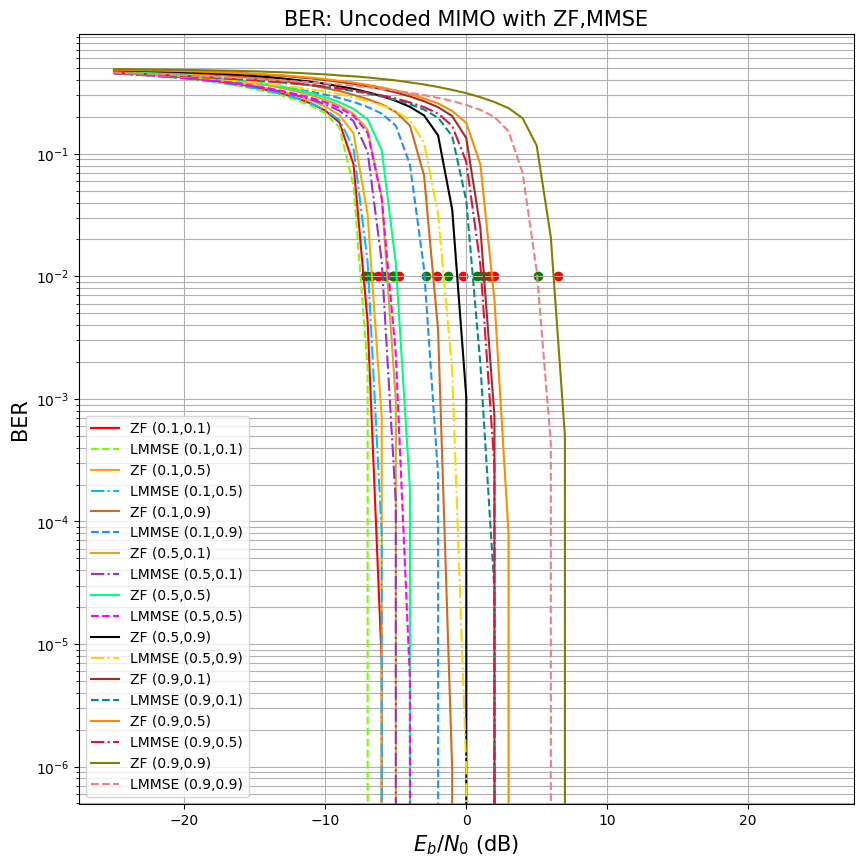

## 3.3 BER simulations using a Keras model

In [129]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

# sionna.config.xla_compat=True
sn.config.xla_compat=True
class Model(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = 1024
        self.k = 512
        self.coderate = self.k/self.n
        self.num_bits_per_symbol = 4
        self.num_tx_ant = 4
        self.num_rx_ant = 16
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)

    # @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)

        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)

        x_hat, no_eff = lmmse_equalizer(y, h, s)

        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)

        return b,  b_hat

ber_plot = PlotBER()
model1 = Model()

ber_plot.simulate(model1,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=100,
        legend="Uncorrelated",
        show_fig=False);

num_tx_ant = 4
num_rx_ant = 16
r_tx = exp_corr_mat(0.4, num_tx_ant)
r_rx = exp_corr_mat(0.7, num_rx_ant)
model2 = Model(KroneckerModel(r_tx, r_rx))

ber_plot.simulate(model2,
        np.arange(0,2.6,0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=200,
        legend="Kronecker model");

Number of GPUs available : 0
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 1.1082e-01 | 9.1754e-01 |      929618 |     8388608 |        15033 |       16384 |        69.4 |reached target block errors
    -2.25 | 7.9529e-02 | 7.8729e-01 |      667139 |     8388608 |        12899 |       16384 |        72.0 |reached target block errors
     -2.0 | 5.0750e-02 | 5.9467e-01 |      425719 |     8388608 |         9743 |       16384 |        71.7 |reached target block errors
    -1.75 | 2.6368e-02 | 3.6487e-01 |      221191 |     8388608 |         5978 |       16384 |        73.8 |reached target block errors
     -1.5 | 1.2233e-02 | 1.9684e-01 |      102620 |     8388608 |         3225 |       16384 |        75.5 |reached target block errors
    -1.25 | 4.6934e-03 | 8.1238e-02 

KeyboardInterrupt: 

# 4 Uncoded MIMO OFDM SER under Flat Fading Channel

<img style="float: left;" src="/Users/im/Documents/GitHub/sionna/Figures/Part 4 Toward Learned Receivers.png" width="40%"> 
<img style="float: left;" src="/Users/im/Documents/GitHub/sionna/Figures/Part 4 Neural Receiver.png" width="55%">

In [ ]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

CODERATE = 0.5
n = 1024
k = int(n*CODERATE) # Block Length: 512
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallelly Processed Batches
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
# print('snrs[25] =',snrs[25])
bers_zf = np.zeros((9, 51))
bers_lmmse = np.zeros((9, 51))
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

###############################
# Stream Management
###############################

# Define the number of UT and BS antennas
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 4
NUM_BS_ANT = 16

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
NUM_STREAMS_PER_TX = NUM_UT_ANT

# Create an RX-TX association matrix.
# RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change.
# For example, considering a system with 2 RX and 4 TX, the RX-TX
# association matrix could be
# [ [1 , 1, 0, 0],
#   [0 , 0, 1, 1] ]
# which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
# TX 2 and 3.
#
# In this notebook, as we have only a single transmitter and receiver,
# the RX-TX association matrix is simply:
RX_TX_ASSOCIATION = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

###############################
# OFDM Resource Grid
###############################
RESOURCE_GRID = sn.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])
# RESOURCE_GRID.show();

# RESOURCE_GRID.pilot_pattern.show();

###############################
# Antenna Arrays
###############################
CARRIER_FREQUENCY = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

UT_ARRAY = sn.channel.tr38901.Antenna(  polarization="single", # Either “single” or “dual”
                                        polarization_type="V", # For single polarization, must be “V” or “H”. For dual polarization, must be “VH” or “cross”.
                                        antenna_pattern="38.901", # Antenna radiation pattern, either “omni” or “38.901”
                                        carrier_frequency=CARRIER_FREQUENCY) # Carrier frequency [Hz]
# UT_ARRAY.show();
# UT_ARRAY.show_element_radiation_pattern();

BS_ARRAY = sn.channel.tr38901.AntennaArray( num_rows=1, # Number of rows of elements
                                            num_cols=int(NUM_BS_ANT/2), # Number of columns of elements
                                            polarization="dual", # Either “single” or “dual”
                                            polarization_type="cross", # For single polarization, must be “V” or “H”. For dual polarization, must be “VH” or “cross”.
                                            antenna_pattern="omni", # Antenna radiation pattern, either “omni” or “38.901”
                                            carrier_frequency=CARRIER_FREQUENCY) # Carrier frequency [Hz]
# BS_ARRAY.show();
# BS_ARRAY.show_element_radiation_pattern();

###############################
# Channel Model: 3GPP CDL
###############################
# 1. 3GPP TR 38.901: CDL, TDL, UMi, UMa, and RMa
# TDL: only supports SISO; corresponds to fixed power delay profiles and fixed angles
# CDL: only supports single-user, possibly with multiple antenna; corresponds to fixed power delay profiles and fixed angles
# UMi, UMa, and RMa: support single- and multi-user
# 2. Rayleigh block fading

DELAY_SPREAD = 100e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value.

DIRECTION = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.

CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]

SPEED = 10.0          # UT speed [m/s]. BSs are always assumed to be fixed.
                     # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
CDL = sn.channel.tr38901.CDL(CDL_MODEL, # One of “A”, “B”, “C”, “D” or “E”.
                             DELAY_SPREAD, # RMS delay spread [s]
                             CARRIER_FREQUENCY, # Carrier frequency [Hz]
                             UT_ARRAY, # Panel array used by the UTs.
                             BS_ARRAY, # Panel array used by the Bs.
                             DIRECTION, # Link direction. Either “uplink” or “downlink”.
                             min_speed=SPEED) # Minimum speed [m/s]. Defaults to 0.

BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel

a, tau = CDL(batch_size=BATCH_SIZE,
             num_time_steps=RESOURCE_GRID.num_ofdm_symbols,
             sampling_frequency=1/RESOURCE_GRID.ofdm_symbol_duration)
            # a([batch size, num_rx = 1, num_rx_ant, num_tx = 1, num_tx_ant, num_paths, num_time_steps], tf.complex)
            # tau ([batch size, num_rx = 1, num_tx = 1, num_paths], tf.float) – Path delays [s]

# print("Shape of the path gains: ", a.shape)
# print("Shape of the delays:", tau.shape)

# plt.figure()
# plt.title("Channel impulse response realization")
# plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
# plt.xlabel(r"$\tau$ [ns]")
# plt.ylabel(r"$|a|$")


# plt.figure()
# plt.title("Time evolution of path gain")
# plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
# plt.plot(np.arange(RESOURCE_GRID.num_ofdm_symbols)*RESOURCE_GRID.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
# plt.legend(["Real part", "Imaginary part"])

# plt.xlabel(r"$t$ [us]")
# plt.ylabel(r"$a$");

###############################
# Configure and Instance Function Components of the System Model 
###############################

# Binary Source: creates batches of information bits
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# LDPC Encoder: maps information bits to coded bits
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# Mapper: maps blocks of information bits to constellation symbols
mapper = sn.mapping.Mapper(constellation=constellation)

# Resource Grid Mapper: maps symbols onto an OFDM resource grid
rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# Frequency Domain channel
tr38901_CDL_channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

# OFDM LS Channel Estimator: provides channel estimates and error variances
ofdm_ls_estimator = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

# OFDM LMMSE Equalizer: provides soft symbols together with noise variance estimates
ofdm_lmmse_equalizer = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

# Symbol Demapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# Demapper: produces LLR for all coded bits
demapper = sn.mapping.Demapper("app", constellation=constellation)

# LDPC Decoder: provides hard-decisions on the information bits
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

###############################
# Uplink Transmission in the Frequency Domain
###############################

# Transmitter
b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)

x_rg = rg_mapper(x)

x_rg_reshape = tf.reshape(x_rg,[-1, NUM_TX_ANT])
# print('x reshape =',x_reshape.shape)

x_reshape

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# Adding Spatial Correlation
# Create transmit and receive correlation matrices
for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)

        # Add the spatial correlation model to the channel
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51):

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0,
                                    resource_grid=RESOURCE_GRID) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # Channel

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_rg_reshape, no])
            # print('h.shape =\n',h.shape)
            # print('h =',h)
            # print('y.shape =\n',y.shape)

            # Receiver

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            no_eff_zf = tf.reshape(no_eff_zf, shape)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        # plt.text(snrs[25], sers_zf[i][25], '({},{}).format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX)', \
        #          fontsize=8, color = "r", style = "italic", weight = "light", verticalalignment='center', \
        #          horizontalalignment='right', rotation=90)
        plt.scatter(snrs[25], sers_zf[i][25], marker='o', color='red')
        plt.scatter(snrs[25], sers_lmmse[i][25], marker='o', color='green')
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=10)
        i = i + 1
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()
